# Neural Style Transfer

- Implement the neural style transfer algorithm (created by  [Gatys et al. (2015).](https://arxiv.org/abs/1508.06576))
- Generate novel artistic images using this algorithm

<img src="images/louvre_generated.png" style="width:750px;height:200px;">

In [1]:
# import packages
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from nst_utils import *
import numpy as np
import tensorflow as tf
import pprint
%matplotlib inline

## 1 - Transfer Learning

We'll use a VGG-19 network which has been trained on the very large imageNet database.

In [2]:
# load the model
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
pp.pprint(model)

{   'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>,
    'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>,
    'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>,
    'avgpool4': <tf.Tensor 'AvgPool_3:0' shape=(1, 19, 25, 512) dtype=float32>,
    'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 10, 13, 512) dtype=float32>,
    'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>,
    'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>,
    'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>,
    'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) 

- The model is stored in a python dictionary.
- The python dictionary contains key-value pairs for each layer.
- The key is the variable name and the value is a tensor for that layer.

## 2 - Neural Style Transfer (NST)

We will build the Neural Style Transfer (NST) algorithm in three steps:

- Build the content cost function $J_{content}(C,G)$
- Build the style cost function $J_{style}(S,G)$
- Put it together to get $J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$. 

### 2.1 - Computing the content cost

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2\tag{1} $$

1. Forward propagate image "C" and "G" to get $a^{(C)}$ and $a^{(G)}$.
2. Unroll $a^{(C)}$ and $a^{(G)}$ from 3D to 2D matrices.
3. Choose a **middle** activation layer to compute the content cost.

In [3]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_C_unrolled = tf.reshape(a_C, shape=[m, -1, n_C])
    a_G_unrolled = tf.reshape(a_G, shape=[m, -1, n_C])
    
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_G_unrolled, a_C_unrolled))) / (4 * n_H * n_W * n_C )
    
    return J_content

In [4]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


### 2.2 - Computing the style cost

#### 2.2.1 - Style Matrix / Gram Matrix

The style of an image can be represented using the Gram matrix of a hidden layer's activations:

$$\mathbf{G}_{gram} = \mathbf{A}_{unrolled} \mathbf{A}_{unrolled}^T$$


- $G_{(gram)i,j}$: correlation of filter $i$ and $j$
- $G_{(gram),i,i}$: prevalence of filter $i$

In [5]:
def gram_matrix(A):
    GA = tf.matmul(A, tf.transpose(A))
    return GA

#### 2.2.2 - Style Cost

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2\tag{2} $$

Note: Since the activation dimensions are $(m, n_H, n_W, n_C)$ whereas the desired unrolled matrix shape is $(n_C, n_H*n_W)$, the order of the filter dimension $n_C$ is changed.  So `tf.transpose` can be used to change the order of the filter dimension.

In [6]:
def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    a_S = tf.transpose(a_S, perm=[0, 3, 1, 2])
    a_S = tf.reshape(a_S, shape=[n_C, n_H*n_W])
    a_G = tf.transpose(a_G, perm=[0, 3, 1, 2])
    a_G = tf.reshape(a_G, shape=[n_C, n_H*n_W])
    
    G_S = gram_matrix(a_S)
    G_G = gram_matrix(a_G)
    
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(G_S, G_G))) / (2 * n_C * n_H * n_W) ** 2
    
    return J_style_layer

#### 2.2.3 - Style Weights

We can get better results by combining Gram matrices from multiple different layers:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

In [8]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [9]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    J_style = 0
    
    for layer_name, coeff in STYLE_LAYERS:
        out = model[layer_name]
        a_S = sess.run(out)
        a_G = out
        J_style += coeff * compute_layer_style_cost(a_S, a_G)
    
    return J_style

### 2.3 - Defining the total cost to optimize

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [10]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """
    
    J = alpha * J_content + beta * J_style
    
    return J

### 2.4 - Solving the optimization problem

Steps:

1. Create an Interactive Session
2. Load the content image 
3. Load the style image
4. Randomly initialize the image to be generated 
5. Load the VGG19 model
7. Build the TensorFlow graph:
    - Run the content image through the VGG19 model and compute the content cost
    - Run the style image through the VGG19 model and compute the style cost
    - Compute the total cost
    - Define the optimizer and the learning rate
8. Initialize the TensorFlow graph and run it for a large number of iterations, updating the generated image at every step.

In [11]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

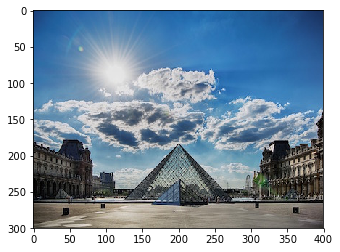

In [12]:
# load the content image
content_image = scipy.misc.imread('images/louvre_small.jpg')
imshow(content_image);
content_image = reshape_and_normalize_image(content_image)

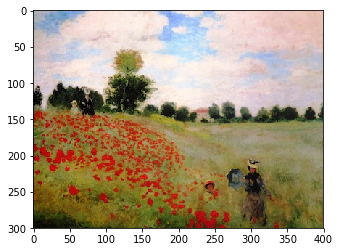

In [13]:
# load the style image
style_image = scipy.misc.imread('images/monet.jpg')
imshow(style_image)
style_image = reshape_and_normalize_image(style_image)

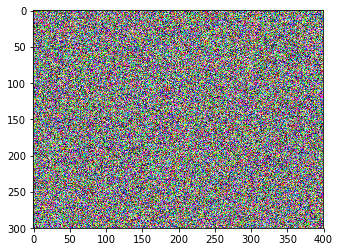

In [14]:
# Random initialize the generated image
generated_image = generate_noise_image(content_image)
imshow(generated_image[0]);

In [15]:
# Load pre-trained VGG-19 model
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [16]:
# Compute the content cost

# Assign the content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# Select the output tensor of layer conv4_2
out = model['conv4_2']

# Set a_C to be the hidden layer activation from the layer we have selected
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. Here, a_G references model['conv4_2'] 
# and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
# when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
a_G = out

# Compute the content cost
J_content = compute_content_cost(a_C, a_G)

In [17]:
# Compute the style cost

# Assign the input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

# Compute the style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [18]:
# total cost
J = total_cost(J_content, J_style)

In [19]:
# define optimizer (1 line)
optimizer = tf.train.AdamOptimizer(2.0)

# define train_step (1 line)
train_step = optimizer.minimize(J)

In [20]:
def model_nn(sess, input_image, num_iterations = 200):
    sess.run(tf.global_variables_initializer())
    
    sess.run(model['input'].assign(input_image))
    
    for i in range(num_iterations):
        sess.run(train_step)
        
        generated_image = sess.run(model['input'])
        
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            # save current generated image in the "/output" directory
            save_image("output/" + str(i) + ".png", generated_image)
    
    # save last generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

In [21]:
model_nn(sess, generated_image)

Iteration 0 :
total cost = 5.0634e+09
content cost = 7865.72
style cost = 1.26583e+08
Iteration 20 :
total cost = 9.58079e+08
content cost = 15071.3
style cost = 2.39482e+07
Iteration 40 :
total cost = 4.85397e+08
content cost = 16643.6
style cost = 1.21308e+07
Iteration 60 :
total cost = 3.12107e+08
content cost = 17404.8
style cost = 7.79833e+06
Iteration 80 :
total cost = 2.31019e+08
content cost = 17771.4
style cost = 5.77103e+06
Iteration 100 :
total cost = 1.84701e+08
content cost = 18021.3
style cost = 4.61302e+06
Iteration 120 :
total cost = 1.53601e+08
content cost = 18204.9
style cost = 3.83547e+06
Iteration 140 :
total cost = 1.30995e+08
content cost = 18340.2
style cost = 3.27029e+06
Iteration 160 :
total cost = 1.13687e+08
content cost = 18464.8
style cost = 2.83756e+06
Iteration 180 :
total cost = 1.00043e+08
content cost = 18557.4
style cost = 2.49643e+06


array([[[[ -50.83645248,  -28.88747406,   25.66574669],
         [ -39.80216217,    7.63607597,   26.08360481],
         [ -25.39347839,  -18.35003853,   14.71047592],
         ..., 
         [   6.78127861,  -61.6828537 ,   -2.87848473],
         [ -17.31868172,  -52.24042892,   11.6205101 ],
         [ -19.7683506 ,  -75.88628387,   24.68441582]],

        [[ -64.70055389,   -4.15054226,   58.2013092 ],
         [ -32.69051743,  -11.78989315,   26.29741096],
         [ -22.75208092,   -5.88453722,    2.54841208],
         ..., 
         [   0.18412289,  -80.43173218,    2.4823966 ],
         [  -9.21544552,  -56.39355469,    6.90754843],
         [ -14.82153416,  -68.403862  ,   -4.96114588]],

        [[ -45.57534027,   -4.74785233,   37.57688904],
         [ -41.1931572 ,  -19.59252548,   15.79600143],
         [  -7.68883657,  -21.95430565,    1.19950497],
         ..., 
         [   4.58118868,  -64.29328156,  -25.59484291],
         [  -8.62334538,  -64.9402771 ,   -1.11574352],

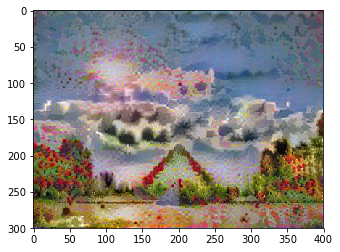

In [22]:
# Show the generated image
generated_image = scipy.misc.imread("output/generated_image.jpg")
imshow(generated_image)